In [42]:
# import pyrochlore_geometry as geom
import numpy as np
import scipy.optimize as opt


import matplotlib.pyplot as plt
import matplotlib as mpl


tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'text.latex.preamble':r"\usepackage{amsmath}"
}

plt.rcParams.update(tex_fonts)



In [128]:


def Jring(Jpm, B):
    # assumes units of Jy
    ring_normals = np.array([ [1.,1,1], [1,-1,-1],[-1,1,-1],[-1,-1,1]])/R3
    
    return (3/2) * Jpm**3 - (5/4) * Jpm**2 * (ring_normals @ B)**2


def energy_cost(b, gvec):
    return np.dot(gvec, np.cos(b))

def energy_der(b, gvec):
    return gvec* -np.sin(b)

def energy_hess(b, gvec):
    return -np.diag(gvec* np.cos(b))



region_constr = opt.LinearConstraint(np.eye(4), lb=-np.pi*np.ones(4),ub=(np.pi+0.1)*np.ones(4) )

def best_flux_fast(Jring):
    best_fun = np.sum(np.abs(Jring)) +1
    res = None

    for s in [-2*np.pi, 0, 2*np.pi, 4*np.pi]:
        vison_constr = opt.LinearConstraint(np.ones(4), s,s)
        r = opt.minimize(energy_cost, [0,0,0,0], args=Jring,
                       method='trust-constr',
                       constraints = [region_constr, vison_constr],
                       jac = energy_der,
                       hess= energy_hess,
                       tol=1e-15
                       )
        if r['fun'] < best_fun:
            best_fun = r['fun']
            res = r

        
    return res

In [36]:
from scipy.spatial.transform import Rotation as R

def is_unit(w, tol=1e-10):
    return np.abs(np.linalg.norm(w) - 1) < tol

def sphere_path(waypoints, dtheta=0.01):
    '''
    @param waypoints -- An array of three-vectors, assumedo n the unit sphere.
    @param dtheta -- arclength spacing.

    @return 
        t -- an array of length len(waypoints) giving the indices of the waypoints.
        path --- an array of shape (len(waypoints), 3) giving the path.
    '''
    path = []
    t = []

    unit_waypoints = [w/np.linalg.norm(w) for w in waypoints]

    w0 = unit_waypoints[0]
    for w in unit_waypoints[1:]:
        # compute normal vector
        n = np.cross(w0, w)
        n /= np.linalg.norm(n)
        delta_theta = np.arccos(np.dot(w0, w))
        
        # if delta_theta < 0.1*dtheta:
        #     continue
        t.append(len(path))
        
        for tau in np.linspace(0, delta_theta-dtheta, int(delta_theta/dtheta) ):
            path.append(R.from_rotvec(tau * n).as_matrix() @ w0)
        w0 = w

    path.append(unit_waypoints[-1])
    t.append(len(path))
    # return t, path

    return np.array(t), np.array(path)


In [37]:


# Sphereical octant projection setup

# distance to 111 plane
d= 2
# viewer distance
fov = 4

R3 = np.sqrt(3)
R6 = np.sqrt(6)
R2 = np.sqrt(2)

# def XY_to_xyz(X, Y):
#     x =  d/R3      + 2*Y/R6 
#     y = d/R3 + X/R2 - Y/R6 
#     z = d/R3 - X/R2 - Y/R6
#     l = (x**2 + y**2 + z**2)**-0.5
    
#     return (x*l, y*l, z*l)

# def xyz_to_XY(x,y,z):
#     L = x + y + z
#     X = R6 * d * ( -y + z) / L / 2
#     Y = R6 * d * ( -2*x + y + z) / L / 2
#     return np.array((X, Y)).T

def XY_to_xyz(X, Y):
    Mu = -3*d*fov + 3 * fov**2  - R3*np.sqrt(( d-fov)**2 + (1 - fov**2)*(X*X+Y*Y) )
    Mu /= (3*fov**2 - 1)
    
    x = (d - fov + R2*Y + fov*Mu)/Mu
    y = (2*R3*d - 2*R3*fov + 3*R2*X - R6*Y + 2*R3*fov*Mu)/(2.*R3*Mu)
    z = (2*R3*d - 2*R3*fov - 3*R2*X - R6*Y + 2*R3*fov*Mu)/(2.*R3*Mu)
    
    return (x, y, z)

def xyz_to_XY(x,y,z):
    l = (x**2 + y **2 + z**2)**-0.5
    x *= l
    y *= l
    z *= l
    denom = (3*fov - x - y - z)
    X = -0.5*(R6*d*y - R6*fov*y - R6*d*z + R6*fov*z)/denom
    Y = -((d - fov)*(2*x - y - z))/R2 / denom
    return (X, Y)
    



In [38]:
def calc_fluxgrid(jpm, B0, ntheta = 30, nphi=30):
    points = []
    fluxes = []
    for t in np.linspace(0,np.pi/2, ntheta):
        for phi in np.linspace(0, np.pi/2, 2+int(nphi*np.sin(t))):
            points.append( np.array([np.sin(t)*np.cos(phi), np.sin(t)*np.sin(phi), np.cos(t)]))
            fluxes.append(best_flux_fast(Jring(jpm,B0*np.array(points[-1])))['x'])
            
    return points, fluxes
        

In [39]:
def calc_fluxgrid_sym(jpm, B0, nradial = 20, npolar=20):
    points = []
    fluxes = []
    # strategy: 
    # 1. generate points uniformly in the triangle formed between [111]/r3, [100] and [010]
    # 2. Rotate to be threefold symmetric 
    u1 = np.array([1-R3,1,1])/R3
    u2 = np.array([1,1-R3,1])/R3
    u3 = np.array([-1,1,0])/R2

    
    
    for x in np.linspace(0,1,nradial,endpoint=False):
        for y in np.linspace(0,R2*(1-x),int(npolar* R2*(1-x) ) + 1,endpoint=False ):
            v = x * u1 + y*u3 + [1,0,0]
            points.append( v / np.linalg.norm(v) )

    points = np.vstack((
        points,
        # np.roll(points,1, axis=1),
        # np.roll(points,2, axis=1),
        [np.array([1,1,1])/np.sqrt(3),]
    ))

            
    for p in points:
        fluxes.append(best_flux_fast(Jring(jpm,B0*np.array(p)))['x'])
            
    return points, fluxes

In [18]:
jpm = 0.015


In [40]:
res_weak   = calc_fluxgrid_sym(jpm = jpm, B0=np.sqrt( 3.6*jpm)*0.8 ,  nradial = 100, npolar=100) 
res_crit   = calc_fluxgrid_sym(jpm = jpm, B0=np.sqrt( 3.6*jpm)     ,  nradial = 100, npolar=100)

np.save('data/weak_pts.npy', res_weak[0])
np.save('data/weak_flux.npy', res_weak[1])
np.save('data/crit_pts.npy', res_crit[0])
np.save('data/crit_flux.npy', res_crit[1])

In [41]:
res_strong = calc_fluxgrid_sym(jpm = jpm, B0=np.sqrt( 3.6*jpm)*1.2 ,  nradial = 100, npolar=100)
np.save('data/strong_pts.npy', res_strong[0])
np.save('data/strong_flux.npy', res_strong[1])

In [9]:
# Load saved files

res_weak = (np.load('data/weak_pts.npy'),np.load('data/weak_flux.npy'))
res_crit = (np.load('data/crit_pts.npy'),np.load('data/crit_flux.npy'))
res_strong = (np.load('data/strong_pts.npy'),np.load('data/strong_flux.npy'))

In [21]:


def phasefun_new(flux):
    if np.abs(np.sum(np.cos(flux))) < 1e-2:
        return 2
    elif np.allclose(np.cos(flux), [1,1,1,1], 1e-3):
        return 1 # 0 flux
    elif np.allclose(np.cos(flux), [-1,-1,-1,-1], 1e-3):
        return 0 # pi flux
    return 3


In [50]:
phases = [
    {
        'name': r"$U(1)_\pi$",
        'cond': lambda r : np.all(np.isclose(np.cos(r), -1*np.ones(4),1e-2),axis=-1),
        'color': "#593a6d", # "#212738",
        'tcolor': 'w'
    },
    {
        'name': "$U(1)_0$",
        'cond': lambda r : np.all(np.isclose(np.cos(r), np.ones(4),1e-2), axis=-1),
        'color': "#EDF2EF",
        'tcolor': 'k'
    },
    {
        'name': r"$\pi\pi00$",
        'cond': lambda r : np.all(
            np.isclose(np.cos(r), [-1,-1,1,1],1e-1),
        axis=-1)  ,
        'color': "#57C4E5",
        'tcolor': 'k'
    },
    {
        'name': "FF",
        'cond': lambda r : np.logical_not(np.isclose(r[:,:,1], 0, 1e-1) | np.isclose( np.abs(r[:,:,1]), np.pi, 1e-1)),
        'color': "#F97068",
        'tcolor': 'k'
    }
]

In [51]:

def plot_phasedia(ax, points, flux_data, downsample=1):
   XY = xyz_to_XY(*np.array(points)[::downsample].T)
   phase_data = [phasefun_new(p) for p in flux_data]
   c = phase_data[::downsample]
   lvl = [-0.5, 0.5,1.5,2.5,3.5]
   sm = ax.tricontourf(*XY, c, 
                  levels=lvl,
               colors=[p['color'] for p in phases], rasterized=True)
   ax.tricontour(*XY, c, levels=lvl, colors=['k' for i in range(4)])
   ax.axis('equal')

   def add_annotation(text, x,y,z, delta=[0.01,0.01], color='k', point=True, ms=1, **kwargs):
      Xy = xyz_to_XY(np.array(x, dtype=np.float64),
                                    np.array(y, dtype=np.float64),
                                    np.array(z, dtype=np.float64))
      if point:
         ax.plot(*Xy, 'o',color=color, ms=ms)
      ha = ['center', 'left', 'right'][int(np.sign(delta[0]))]
      va = ['center', 'bottom', 'top'][int(np.sign(delta[1]))]
      
      ax.annotate(text, xy=Xy, xytext= np.array(Xy) + delta, horizontalalignment=ha, verticalalignment=va, color=color, **kwargs)

   arrow_args = dict(
      zorder=-2, width=0.002, head_width =0.012, color='k'
   )

   ax.arrow(0,0,1.2*xyz_to_XY(1,0,0)[0],1.2*xyz_to_XY(1,0,0)[1], **arrow_args)
   ax.arrow(0,0,1.2*xyz_to_XY(0,1,0)[0],1.2*xyz_to_XY(0,1,0)[1], **arrow_args)
   ax.arrow(0,0,1.2*xyz_to_XY(0,0,1)[0],1.2*xyz_to_XY(0,0,1)[1], **arrow_args)
   ax.axis('off')

   return add_annotation, sm



/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1364710722.py:6: UserWarning: The following kwargs were not used by contour: 'rasterized'
  sm = ax.tricontourf(*XY, c,


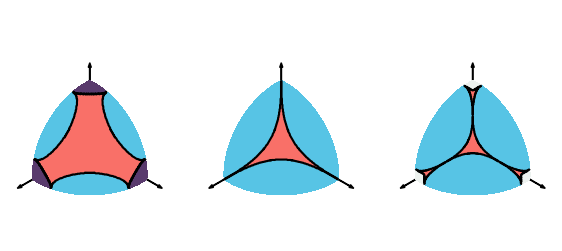

In [52]:
fig, Ax = plt.subplots(ncols=3, figsize=(7,3))

for j, res in enumerate([res_weak, res_crit, res_strong]):
    points = np.vstack((
        res[0],
        np.roll(res[0][:-1],1, axis=1),
        np.roll(res[0][:-1],2, axis=1)
    ))
    flux = np.vstack((
        res[1],res[1][:-1],res[1][:-1]
    ))

    annotate, sm = plot_phasedia(Ax[j], points, flux, downsample=1)
# XY = xyz_to_XY(*np.array(res_weak[0]).T)
# Ax[0].tricontourf(*XY, np.array(res_weak[1])[:,0])
# Ax[1].tricontourf(*XY, np.array(res_crit[1])[:,0])
# Ax[2].tricontourf(*XY, np.array(res_strong[1])[:,0])


In [44]:
targs = dict(
   fontsize=8,
   color='k',
   ms=2,
   zorder= 500,
)

plargs = dict(
   fontsize=10,
   point=False
)

<>:99: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
<>:99: SyntaxWarning: invalid escape sequence '\p'
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1690927445.py:99: SyntaxWarning: invalid escape sequence '\p'
  ax2.set_yticklabels(['$-\pi$', 0,'$\pi$'])
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1690927445.py:99: SyntaxWarning: invalid escape sequence '\p'
  ax2.set_yticklabels(['$-\pi$', 0,'$\pi$'])
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1364710722.py:6: UserWarning: The following kwargs were not used by contour: 'rasterized'
  sm = ax.tricontourf(*XY, c,


B = 0.185903200617956


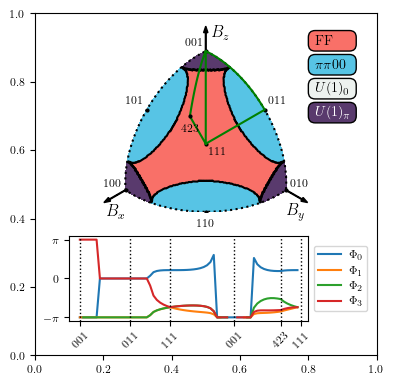

In [53]:

aspect = 1.0

fs= (3.42, 3.42*aspect)

fig = plt.figure(figsize=fs)

ax=fig.add_axes([0,0.42,1,0.57])


points = np.vstack((
    res_weak[0],
    np.roll(res_weak[0][:-1],1, axis=1),
    np.roll(res_weak[0][:-1],2, axis=1)
))
flux = np.vstack((
    res_weak[1],res_weak[1][:-1],res_weak[1][:-1]
))

annotate, sm = plot_phasedia(ax, points, flux, downsample=1)



_, border = sphere_path([(1,0,0),(0,1,0),(0,0,1), (1,0,0)])
ax.plot(*xyz_to_XY(*border.T), 'k:')

def add_annotations(add_annotation):
    add_annotation('111',1,1,1, [0.01,-0.01], **targs)

    add_annotation('011',1,1,0, [0.01,0.01], **targs)
    add_annotation('101',1,0,1, [-0.01,0.01], **targs)
    add_annotation('110',0,1,1, [0.0,-0.02], **targs)

    add_annotation('001',1,0,0, [-0.01,0.01], **targs)
    add_annotation('010',0,1,0, [0.01,0.005], **targs)
    add_annotation('100',0,0,1, [-0.01,0.005], **targs)

def annotate_axes(add_annotation):
    add_annotation(r'$B_z$',1,0,0, [0.015,0.03], fontsize=12, point=False)
    add_annotation(r'$B_y$',0,1,0, [0.001, -0.04], fontsize=12, point=False)
    add_annotation(r'$B_x$',0,0,1, [-0.001,-0.04], fontsize=12, point=False)

pointy_arrow = dict(
        arrowstyle='->',
        color='k'
    )

annotate_axes(annotate)

add_annotations(annotate)

waypoints = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (1, 0, 0), (1, 0.5, 0.75), (1, 1, 1)]

def wrap_array(data, L=2*np.pi, chart_cut=np.pi, mask=True, threshold_percent = 0.9):
    '''
    Returns 'data' wrapped modulo L. 
    '''
    if chart_cut < 0:
        chart_cut = np.remainder(chart_cut, L)
    d = np.mod(data + chart_cut, L) - chart_cut
    if mask:
        # identify cuts
        delta = np.append(np.abs(d[1:] - d[:-1]), [0])
        return np.ma.masked_where(delta > threshold_percent * L, d )
    else:
        return d



def plot_cut(ax, ax2, wp, B0, dtheta = 0.05, rot_lab = 45):
    flux_path = []
    J_path = []

    t, b = sphere_path(wp, dtheta)

    for n in b:
        J_path.append(Jring(jpm,B0*n))
        flux_path.append(best_flux_fast(J_path[-1])['x'])


    flux_path = np.array(flux_path)
    J_path = np.array(J_path)

    ax.plot(*xyz_to_XY(*b.T), 'g-')

    for j, fp in enumerate([ 
        np.abs(flux_path[:,0]), 
        -np.abs(flux_path[:,1]),
        -np.abs(flux_path[:,2]),
        -np.abs(flux_path[:,3])
        ]):

        ax2.plot( wrap_array(fp), label=r'$\Phi_%d$' % j)

    ax2.set_xticks(t)
    ax2.set_xticklabels(['001','011','111','001','423','111'],rotation=rot_lab)
    for tt in t:
        ax2.axvline(tt, color='k', lw=1, ls=':')
    ax2.set_yticks([-np.pi, 0, np.pi])
    ax2.set_yticklabels(['$-\pi$', 0,'$\pi$'])






cax = fig.add_axes([0.85, 0.7, 0.08, 0.2])

#############
##  the legend

cax.axis('off')
for j, p in enumerate(phases):
    x = 0.82
    y= 0.7 + j*0.07
    tt = fig.text(x, y , p['name'], 
        color=p['tcolor']
        )
    fig.add_artist(mpl.patches.FancyBboxPatch((x,y), width=0.1, height=0.02, boxstyle='round,pad=0.02',fc=p['color'], ec='k'))

ax2 = fig.add_axes([0.1,0.1,0.7,0.25])
# ax2 = fig.add_axes([0.1,0.1,0.6,0.7])

plot_cut(ax, ax2, waypoints, B0 = np.sqrt( 3.6*jpm)*0.8)
annotate(r'423', *waypoints[-2], [0,-0.02], **targs)

ax2.legend(loc='center left',bbox_to_anchor=[1,0.5])

fig.savefig("/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG/magnetic_field.pdf", dpi=300,format='pdf')

fig.add_axes([0,0,1,1]).patch.set_alpha(0)

print(f"B = { np.sqrt( 3.6*jpm)*0.8}" )
# jpm

In [54]:
def plot_cut_vertical(ax, ax2, wp, B0, dtheta = 0.05, rot_lab = 45):
    flux_path = []
    J_path = []

    t, b = sphere_path(wp, dtheta)

    for n in b:
        J_path.append(Jring(jpm,B0*n))
        flux_path.append(best_flux_fast(J_path[-1])['x'])


    flux_path = np.array(flux_path)
    J_path = np.array(J_path)

    ax.plot(*xyz_to_XY(*b.T), 'g-')

    for j, fp in enumerate([ 
        np.abs(flux_path[:,0]), 
        -np.abs(flux_path[:,1]),
        -np.abs(flux_path[:,2]),
        -np.abs(flux_path[:,3])
        ]):

        ax2.plot( wrap_array(fp), np.arange(len(fp)), label=r'$\Phi_%d$' % j)

    ax2.set_yticks([])
    props = dict(boxstyle='round', facecolor='white', edgecolor='white', alpha=1, linewidth=0)
    for y, l in zip(t, ['001','011','111','001','423','111']):
        ax2.text(np.pi/3-0.3, y, l, fontsize=6,bbox=props, verticalalignment='center')
    # ax2.set_yticklabels(,rotation=rot_lab)
    # for tt in t:
    ax2.hlines(t, xmin=-np.pi, xmax=np.pi,color='k', lw=0.7, ls=':')
    ax2.set_xticks([-np.pi, 0, np.pi])
    ax2.set_xticklabels([r'$-\pi$', 0,r'$+\pi$'])
    # ax2.set_xlim([-np.pi,np.pi])

/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1364710722.py:6: UserWarning: The following kwargs were not used by contour: 'rasterized'
  sm = ax.tricontourf(*XY, c,


B = 0.185903200617956


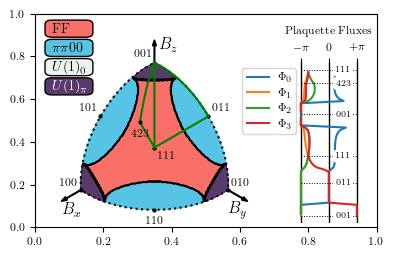

In [55]:
# NEW PAPER VERSION
# NEW NEW PAPER VERSION

aspect = 5/8

fs= (3.42, 3.42*aspect)

fig = plt.figure(figsize=fs)

ax=fig.add_axes([0.05,0,0.6,1])
# cax = fig.add_axes([0.1, 0.6, 0.08, 0.4])
# ax2 = fig.add_axes([0.79,0.1,0.2,0.85]) # good for bottom labeling
ax2 = fig.add_axes([0.77,0.02,0.18,0.75])
ax2.set_title('Plaquette Fluxes',fontsize=8)

points = np.vstack((
    res_weak[0],
    np.roll(res_weak[0][:-1],1, axis=1),
    np.roll(res_weak[0][:-1],2, axis=1)
))
flux = np.vstack((
    res_weak[1],res_weak[1][:-1],res_weak[1][:-1]
))

annotate, sm = plot_phasedia(ax, points, flux, downsample=1)

_, border = sphere_path([(1,0,0),(0,1,0),(0,0,1), (1,0,0)])
ax.plot(*xyz_to_XY(*border.T), 'k:')

pointy_arrow = dict( arrowstyle='->', color='k')
annotate_axes(annotate)
add_annotations(annotate)

waypoints = [(1, 0, 0), (1, 1, 0), (1, 1, 1), (1, 0, 0), (1, 0.5, 0.75), (1, 1, 1)]

#############
## again it is the legend
# cax.axis('off')
for j, p in enumerate(phases):
    x = 0.05
    y= 0.64 + j*0.09
    tt = fig.text(x, y , p['name'], 
        color=p['tcolor']
        )
    fig.add_artist(mpl.patches.FancyBboxPatch((x,y), width=0.1, height=0.04, boxstyle='round,pad=0.02',fc=p['color'], ec='k'))

# ax2.axis('off')
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)

ax2.axvline(-np.pi, color='k', ls='-',lw=1)
ax2.axvline(np.pi, color='k', ls='-',lw=1)
ax2.axvline(0, color='k', ls='-',lw=1)

plot_cut_vertical(ax, ax2, waypoints, B0 = np.sqrt( 3.6*jpm)*0.8)
annotate(r'423', *waypoints[-2], [0,-0.02], **targs)

# ax2.legend(loc='upper left',bbox_to_anchor=[-1.4,1.3])
ax2.legend(loc='upper left',bbox_to_anchor=[-1,1])

fig.savefig("/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG/magnetic_field_shrunk.pdf", dpi=300,format='pdf')

fig.add_axes([0,0,1,1]).patch.set_alpha(0)

print(f"B = { np.sqrt( 3.6*jpm)*0.8}" )
# jpm

/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1364710722.py:6: UserWarning: The following kwargs were not used by contour: 'rasterized'
  sm = ax.tricontourf(*XY, c,
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1364710722.py:6: UserWarning: The following kwargs were not used by contour: 'rasterized'
  sm = ax.tricontourf(*XY, c,
/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/1364710722.py:6: UserWarning: The following kwargs were not used by contour: 'rasterized'
  sm = ax.tricontourf(*XY, c,


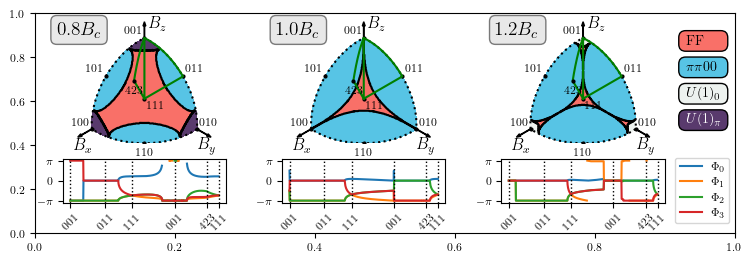

In [33]:
# fig, Ax = plt.subplots(ncols=3,nrows=2, figsize = (7, 3), height_ratios=[2,1])
# fig.subplots_adjust(left=0,right=1,bottom=0,top=0.9)

fig = plt.figure(figsize = (7, 2.2))

Ax = [[], []]
padx = 0.04
for j in range(3):
    w= 1/3 - 0.02
    Ax[0].append(fig.add_axes([j*w, 0.41, w, 0.58]))
    Ax[1].append(fig.add_axes([j*w + padx, 0.14, w-2*padx, 0.2]))

# test
# settings = {'downsample': 30,'dtheta': 0.2, 'save': False}
# production
settings = {'downsample': 1,'dtheta': 0.005, 'save': True}

Bc=  np.sqrt( 3.6*jpm)


Bvals = [0.8*Bc, Bc, 1.2*Bc]
titles = ['0.8$B_c$','$1.0B_c$','1.2$B_c$']

for j, res in enumerate([res_weak, res_crit, res_strong]):
    Ax[0][j].text(0.1,0.85,titles[j],
    transform=Ax[0][j].transAxes, fontsize=14,
    bbox={'facecolor': 'lightgray', 'alpha': 0.5, 'boxstyle': 'round,pad=0.3'}
    )

    points = np.vstack((
        res[0],
        np.roll(res[0][:-1],1, axis=1),
        np.roll(res[0][:-1],2, axis=1)
    ))
    flux = np.vstack((
        res[1],res[1][:-1],res[1][:-1]
    ))

    annotate, sm = plot_phasedia(Ax[0][j], points, flux, downsample=settings['downsample'])
    Ax[0][j].plot(*xyz_to_XY(*border.T), 'k:')    
    add_annotations(annotate)
    annotate_axes(annotate)

    plot_cut(Ax[0][j],Ax[1][j], waypoints, Bvals[j], settings['dtheta'])
    annotate(r'423', *waypoints[-2], [0,-0.02], **targs)


Ax[1][-1].legend(loc='upper left', bbox_to_anchor=(1.03,1.15))




#############
##  the legend
# cax = fig.add_axes([0.93, 0.7, 0.08/4, 0.2])
# cax.axis('equal')
# cax.axis('off')
for j, p in enumerate(phases):
    x = 0.93
    y= 0.5 + j*0.12
    tt = fig.text(x, y , p['name'], 
        color=p['tcolor'],
        horizontalalignment='left'
        )
    box = mpl.patches.FancyBboxPatch((x,y), width=0.05, height=0.03, boxstyle='round,pad=0.01',fc=p['color'], ec='k')
    box.set_mutation_aspect(7/2.2)
    fig.add_artist(box)

if settings['save']:
    fig.savefig("/Users/alaricsanders/Documents/gh-papers/Experimentally-Tunable-QED-in-DO-QSI/FIG/magnetic_field_wide.pdf", dpi=300,format='pdf')

fig.add_axes([0,0,1,1]).patch.set_alpha(0)

In [173]:
# THE SSB PLOT

B_vals = np.linspace(0,0.3, 300)
field_direction = np.array([1,1,1])/np.sqrt(3)
jpm = 0.02
fluxes = []
for B in B_vals:
    fluxes.append(best_flux_fast(Jring(jpm,B * field_direction))['x'])
fluxes = np.array(fluxes)            

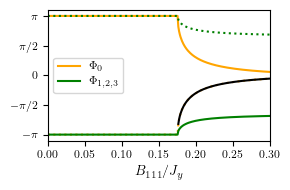

In [243]:
# plt.plot(B_vals,fluxes,'x')
p0 = np.abs(fluxes[:,0])
p1 = -np.abs(fluxes[:,1])

fig,ax = plt.subplots(figsize=(3,2.))

# ax.plot(B_vals,p0,color='orange',label=r'$\Phi_{111}$')
ax.plot(B_vals,p0,color='orange',label=r'$\Phi_{0}$')
ax.plot(B_vals,-p0,':',color='orange')
# ax.plot(B_vals,p1,color='green',label=r'$\Phi_{1\bar{1}\bar{1}}$')
ax.plot(B_vals,p1,color='green',label=r'$\Phi_{1,2,3}$')
ax.plot(B_vals,-p1,':',color='green')
# dummy plots
# ax.plot([],[],color='green',label=r'$\Phi_{\bar{1}1\bar{1}}$')
# ax.plot([],[],color='green',label=r'$\Phi_{\bar{1}\bar{1}1}$')

ax.set_yticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi])
ax.set_yticklabels(f"${s}$" for s in r"-\pi -\pi/2 0 \pi/2 \pi".split() )
ax.set_xlim([0,0.3])

ax.set_xlabel(r"$B_{111}/J_{y}$")
ax.legend()
plt.plot(B_vals, phi0,'k')
fig.tight_layout()

# fig.savefig("/Users/alaricsanders/Desktop/figure_out/SSB_FF.pdf",dpi=300)

In [163]:
Jrings = [Jring(jpm, B*field_direction) for B in B_vals]

In [242]:
phi0 = [1.5*np.arccos(-0.5*(g[1]/g[0]+1))-np.pi for g in Jrings ]

/var/folders/zw/92jnrf1n0710vn256dpg6bsw0000gn/T/ipykernel_23286/3595633764.py:1: RuntimeWarning: invalid value encountered in arccos
  phi0 = [1.5*np.arccos(-0.5*(g[1]/g[0]+1))-np.pi for g in Jrings ]


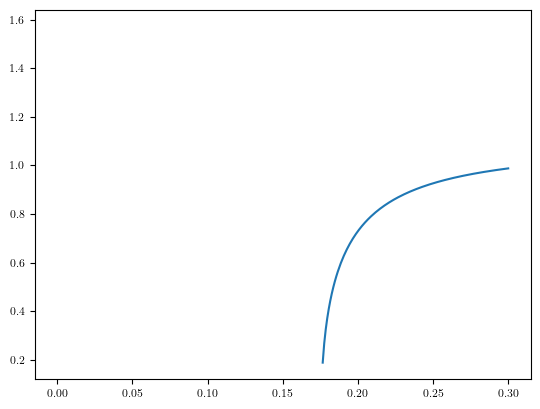

In [234]:
plt.plot(B_vals, phi0)

In [306]:
def g0_g123_ratio_from_flux(desired_Φ0):
    return - np.sin((desired_Φ0-np.pi)/3)/np.sin(desired_Φ0-np.pi)

g0g1 = g0_g123_ratio_from_flux(1.54)


In [307]:
g0g1

-0.5091050350753668

In [309]:
pvals = np.linspace(0.01,np.pi-0.01,100)
y = [best_flux_fast([g0_g123_ratio_from_flux(p),1,1,1]) for p in pvals]



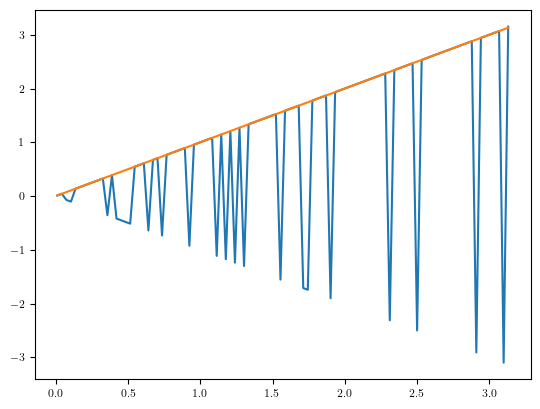

In [311]:
plt.plot(pvals,[yy['x'][0] for yy in y])
plt.plot(pvals, pvals)